# Лабораторная работа №5

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
#### Теперь по пунктам, что я от вас жду:

1. **Загрузить данные** к себе и считать (read) их в переменные.  

2. **Описать постановку задачи**, что от вас хотят.  
   Какие классы, бинарная или многоклассовая классификация, пример реального применения.  
   Показать по 2–3 примера изображений на класс.

3. **Сделать предобработку данных**:  
   - Проверить битые файлы/повреждённые изображения, привести к единому размеру (например, `224×224`).  
   - Нормализовать по каналам (стандарт для ImageNet: mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).  
   - Разделить на **train**/**val** (или **train**/**test**).  
   - Оформить данные в `Dataset`/`ImageFolder` и передать в `DataLoader`.

4. **Провести разведочный анализ данных (EDA)**:  
   - Посчитать количество изображений в каждом классе и оценить дисбаланс.  
   - Построить 1–2 гистограммы/барчарта распределения по классам.  
   - Сделать промежуточные выводы (есть ли редкие классы, артефакты, перекрытие классов и т.п.).

5. **Настроить аугментации** (минимум три): `RandomHorizontalFlip`, `RandomRotation`, `ColorJitter`, `RandomResizedCrop` и др.  
   Коротко описать, почему выбраны именно эти аугментации и как они помогают обобщению.

6. **Выбор и обучение модели**:  
   - Базовый вариант: **transfer learning** на `ResNet18`/`MobileNetV2`/`EfficientNetB0` (предобученные веса).  
   - Заменить выходной слой под число классов.  
   - Задать функцию потерь `CrossEntropyLoss`, оптимизатор (`AdamW`/`SGD`) и расписание обучения (кол-во эпох, `lr`).  
   - В процессе обучения логировать `train loss/acc` и `val loss/acc` по эпохам.  
   - Сохранить лучшую модель по `val acc`/минимальному `val loss`.

7. **Посчитать метрики качества** на **train** и **val/test** множествах:  
   - Для классификации: `Accuracy`, `Precision`, `Recall`, `F1` (macro/micro — обосновать выбор).  
   - Построить **матрицу ошибок (Confusion Matrix)**; ROC-кривые.

8. **Сравнить результаты** (если пробовали несколько моделей/настроек):  
   - Какая модель лучше справилась?  
   - Есть ли переобучение (по кривым обучения)?  
   - Какие классы путаются чаще всего и почему?  
   - Что ещё можно улучшить (аугментации, веса классов, больше данных, регуляризация, тонкая настройка `lr` и т.д.)?

9. **Визуализировать предсказания**:  
   - Показать не менее 10 изображений из валидации/теста с предсказанными и истинными классами.  
   - Пометить корректные (`Y`) и ошибочные (`N`) предсказания, сделать краткие выводы.

---

## P.S.
Просьба — делать каждое задание в отдельных ячейках с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа:
- Заголовок  
- Ячейка с кодом  
- Другой заголовок  
- Другая ячейка с кодом

## P.S.S.
Если у вас **многоклассовая** классификация, убедитесь, что последний слой имеет размерность `num_classes`, а для `CrossEntropyLoss` **не** требуется one-hot.  
При сильном дисбалансе рассмотрите: `class weights` в `CrossEntropyLoss`, oversampling/undersampling.


## 1. Пример импорта данных. Грузим данные

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as å
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: mps


## 2. Понимаем, какая перед нами задача

Всего изображений: 5631
Многоклассовая классификация изображений по 4 категориям:
  0: cloudy
  1: desert
  2: green_area
  3: water

Примеры изображений:


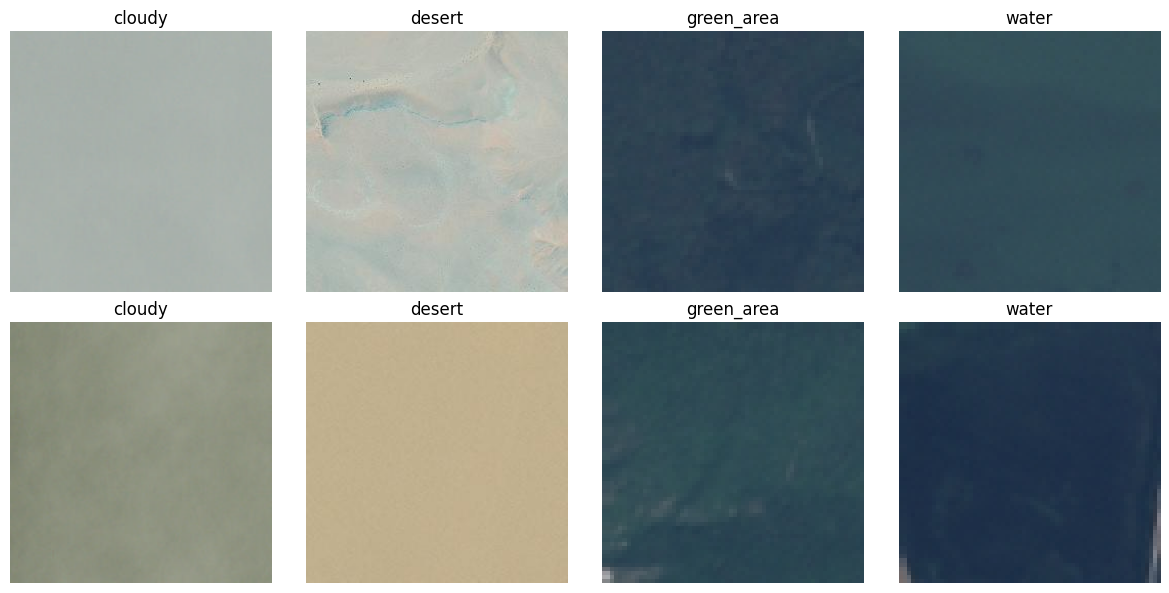

In [13]:
data_path = "../data/lab5"
classes = ["cloudy", "desert", "green_area", "water"]

file_paths = []
labels = []

for label_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    if os.path.exists(class_path):
        files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')]
        file_paths.extend(files)
        labels.extend([label_idx] * len(files))

df = pd.DataFrame({"file_path": file_paths, "label": labels})
print(f"Всего изображений: {len(df)}")

print("Многоклассовая классификация изображений по 4 категориям:")
for idx, class_name in enumerate(classes):
    print(f"  {idx}: {class_name}")

print("\nПримеры изображений:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, class_name in enumerate(classes):
    class_files = df[df["label"] == i]["file_path"].tolist()
    for j in range(2):
        if j < len(class_files):
            img = Image.open(class_files[j])
            axes[j, i].imshow(img)
            axes[j, i].set_title(f"{class_name}")
            axes[j, i].axis('off')
plt.tight_layout()
plt.show()


## 3. Делаем предобработку данных

In [22]:
## 3. Предобработка данных с ПРОВЕРКОЙ на пересечения

def check_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False

print("Проверка целостности изображений...")
valid_files = []
valid_labels = []

for idx, row in df.iterrows():
    if check_image(row["file_path"]):
        valid_files.append(row["file_path"])
        valid_labels.append(row["label"])

df_valid = pd.DataFrame({
    "file_path": valid_files,
    "label": valid_labels
})
print(f"Корректных изображений: {len(df_valid)}")

# Простое разделение БЕЗ лишних проверок
train_df, val_df = train_test_split(
    df_valid,
    test_size=0.2,
    stratify=df_valid["label"],
    random_state=42
)

# Базовая проверка пересечений (по путям)
train_paths = set(train_df["file_path"])
val_paths = set(val_df["file_path"])
common = train_paths.intersection(val_paths)

print(f"\nПроверка разделения:")
print(f"Train: {len(train_df)} изображений")
print(f"Val: {len(val_df)} изображений")
print(f"Пересекающихся файлов: {len(common)}")

if len(common) > 0:
    print(f"Внимание: {len(common)} файлов попали и в train, и в val!")
    # Удаляем пересечения из val
    val_df = val_df[~val_df["file_path"].isin(common)]
    print(f"Исправлено: теперь val имеет {len(val_df)} файлов")

print("\nРаспределение по классам в train:")
print(train_df["label"].value_counts().sort_index())
print("\nРаспределение по классам в val:")
print(val_df["label"].value_counts().sort_index())

Проверка целостности изображений...
Корректных изображений: 5631

Проверка разделения:
Train: 4504 изображений
Val: 1127 изображений
Пересекающихся файлов: 0

Распределение по классам в train:
label
0    1200
1     904
2    1200
3    1200
Name: count, dtype: int64

Распределение по классам в val:
label
0    300
1    227
2    300
3    300
Name: count, dtype: int64


## 4. Разведочный анализ данных (EDA)

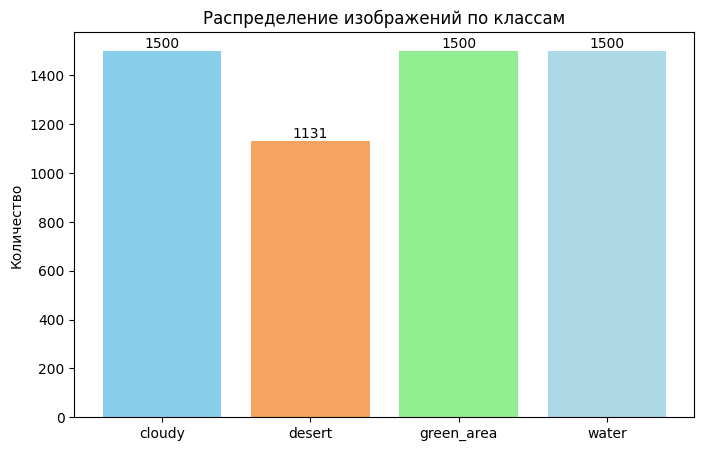

In [23]:
class_counts = df_valid["label"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, class_counts.values, color=['skyblue', 'sandybrown', 'lightgreen', 'lightblue'])
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom')
plt.title("Распределение изображений по классам")
plt.ylabel("Количество")
plt.show()

## 5. Аугментации

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, "file_path"]
        label = self.dataframe.loc[idx, "label"]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_transform)

# УБИРАЕМ num_workers для Mac
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
print("Загрузчики данных созданы.")

Загрузчики данных созданы.


## 6. Выбор и обучение модели

In [25]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Убираем tqdm для DataLoader без multiprocessing
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step()

print(f"Лучшая точность на валидации: {best_val_acc:.4f}")

Epoch 1/10
  Train Loss: 0.0960, Train Acc: 0.9674
  Val Loss: 0.0080, Val Acc: 1.0000
Epoch 2/10
  Train Loss: 0.0329, Train Acc: 0.9871
  Val Loss: 0.0050, Val Acc: 0.9982
Epoch 3/10
  Train Loss: 0.0240, Train Acc: 0.9920
  Val Loss: 0.0062, Val Acc: 0.9965
Epoch 4/10
  Train Loss: 0.0129, Train Acc: 0.9971
  Val Loss: 0.0054, Val Acc: 0.9982
Epoch 5/10
  Train Loss: 0.0177, Train Acc: 0.9951
  Val Loss: 0.0153, Val Acc: 0.9947
Epoch 6/10
  Train Loss: 0.0094, Train Acc: 0.9969
  Val Loss: 0.0013, Val Acc: 1.0000
Epoch 7/10
  Train Loss: 0.0074, Train Acc: 0.9978
  Val Loss: 0.0016, Val Acc: 1.0000
Epoch 8/10
  Train Loss: 0.0040, Train Acc: 0.9993
  Val Loss: 0.0007, Val Acc: 1.0000
Epoch 9/10
  Train Loss: 0.0043, Train Acc: 0.9989
  Val Loss: 0.0021, Val Acc: 0.9991
Epoch 10/10
  Train Loss: 0.0017, Train Acc: 0.9998
  Val Loss: 0.0005, Val Acc: 1.0000
Лучшая точность на валидации: 1.0000


## 7. Метрики качества

Отчет по классификации:
              precision    recall  f1-score   support

      cloudy     1.0000    1.0000    1.0000       300
      desert     1.0000    1.0000    1.0000       227
  green_area     1.0000    1.0000    1.0000       300
       water     1.0000    1.0000    1.0000       300

    accuracy                         1.0000      1127
   macro avg     1.0000    1.0000    1.0000      1127
weighted avg     1.0000    1.0000    1.0000      1127



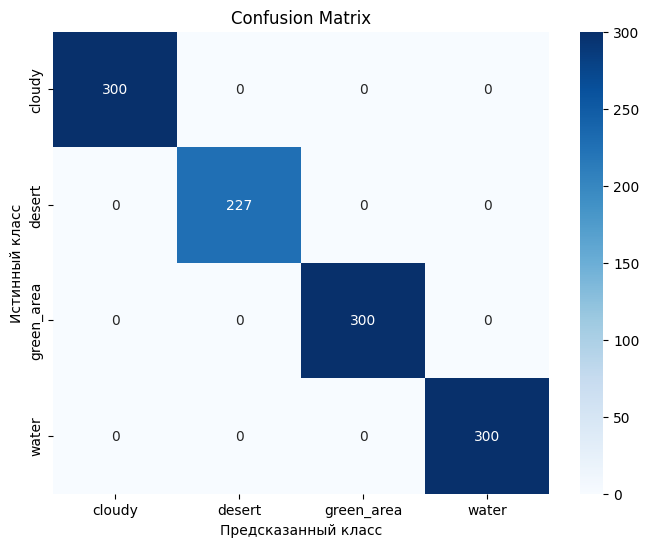

In [26]:
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Отчет по классификации:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

## 8. Сравнение результатов

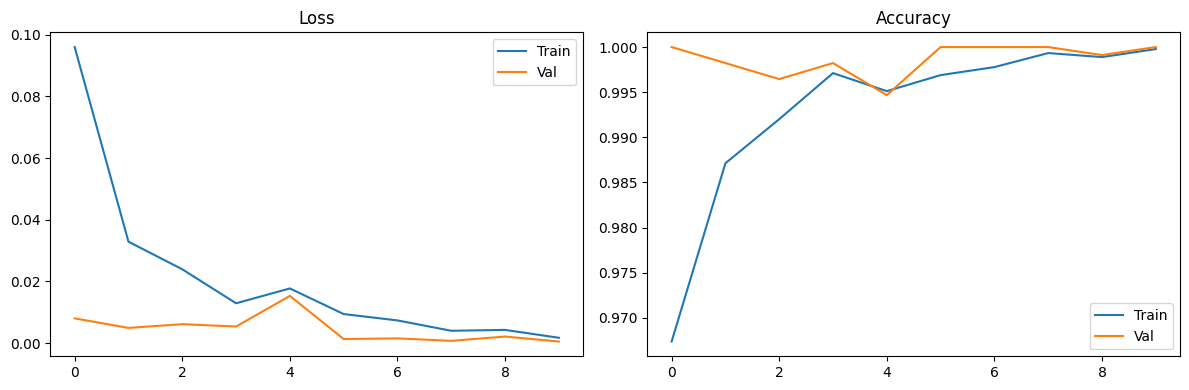

Переобучение наблюдается, если val loss растет, а train loss продолжает уменьшаться.


In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

print("Переобучение наблюдается, если val loss растет, а train loss продолжает уменьшаться.")

## 9. Визуализация предсказаний

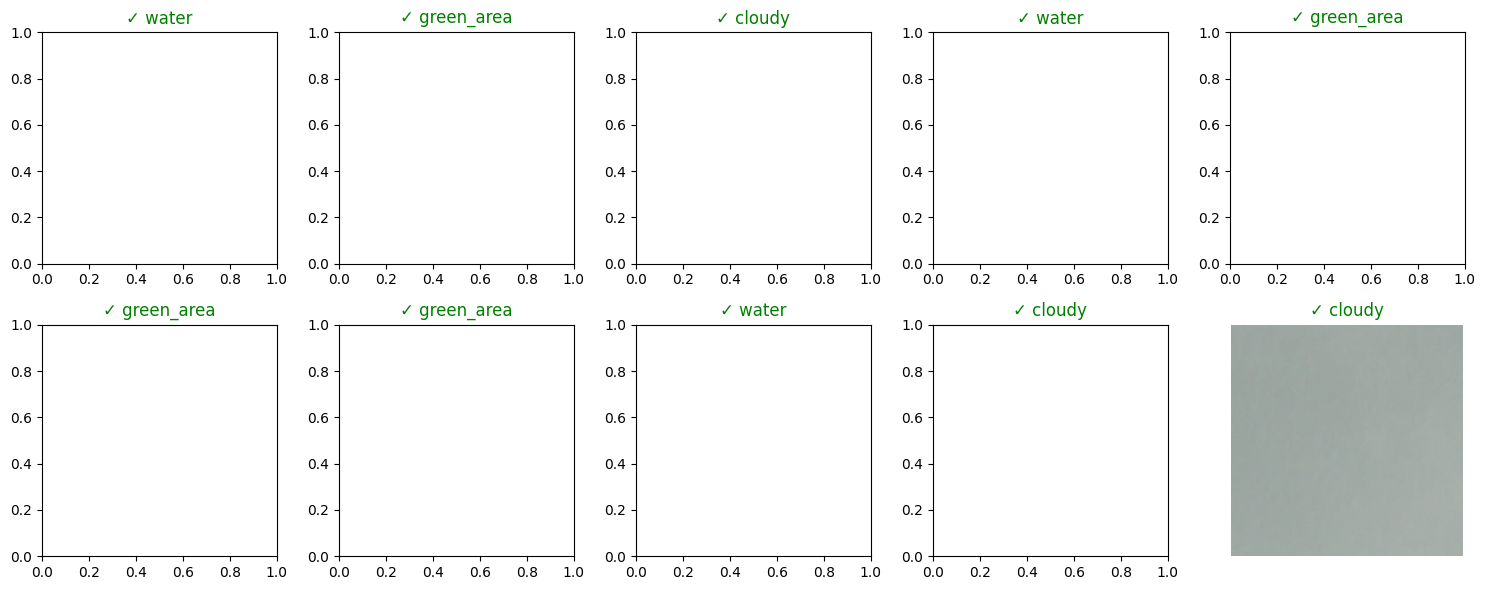

In [28]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

model.eval()
images_shown = 0
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if images_shown >= 10:
                break
            ax = axes[images_shown // 5, images_shown % 5]
            imshow(images[i])
            if labels[i] == preds[i]:
                ax.set_title(f"✓ {classes[labels[i]]}", color='green')
            else:
                ax.set_title(f"✗ {classes[preds[i]]}", color='red')
            images_shown += 1
        if images_shown >= 10:
            break

plt.tight_layout()
plt.show()